## PNEUMONIA DETECTION

BY:
1. ARJUN KAPOOR (akapoor5, 50510484)

2. SAI TEJA ANKURU (saitejaa, 50496340)

## Import Libraries

In [1]:
from IPython.core.interactiveshell import InteractiveShell
import torchvision
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import cv2
from torchsummary import summary
from timeit import default_timer as timer

import time
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

InteractiveShell.ast_node_interactivity = 'all'
print(os.listdir("./chest_xray"))

['test', 'train', 'val']


## Access data directories

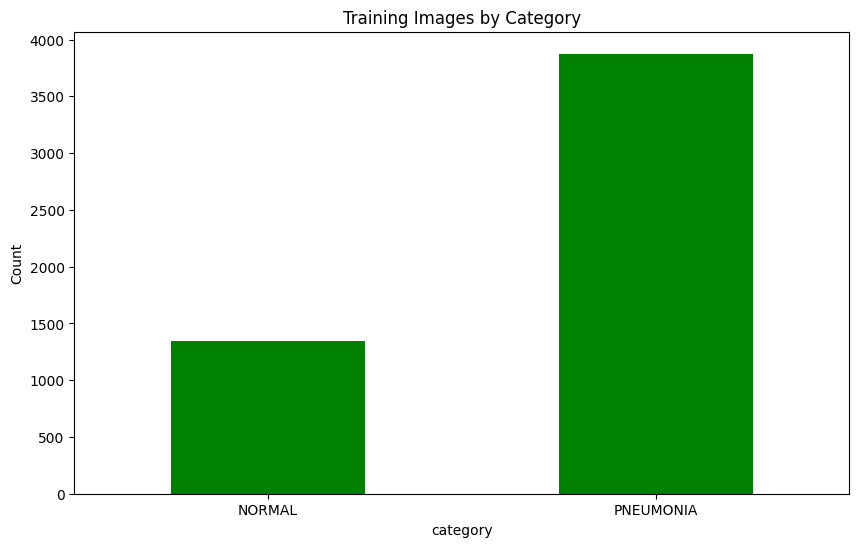

In [2]:
datadir = './chest_xray'
traindir = os.path.join(datadir, 'train')
validdir = os.path.join(datadir, 'val')
testdir = os.path.join(datadir, 'test')

categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []

# Iterate through each category
for category in os.listdir(traindir):
    if not category.startswith('.'):
        categories.append(category)

        # Number of images in each category
        train_imgs = [img for img in os.listdir(os.path.join(traindir, category)) if not img.startswith('.')]
        valid_imgs = [img for img in os.listdir(os.path.join(validdir, category)) if not img.startswith('.')]
        test_imgs = [img for img in os.listdir(os.path.join(testdir, category)) if not img.startswith('.')]
        n_train.append(len(train_imgs))
        n_valid.append(len(valid_imgs))
        n_test.append(len(test_imgs))

        for img_name in train_imgs:
            img_categories.append(category)
            img_path = os.path.join(traindir, category, img_name)
            img = cv2.imread(img_path)
            # Shape
            hs.append(img.shape[0])
            ws.append(img.shape[1])

# Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 'n_test': n_test}).\
    sort_values('category')

# Dataframe of training images
image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws
})

# Plotting of bar chart showing count of images for each label
cat_df.set_index('category')['n_train'].plot.bar(color='g', figsize=(10, 6))
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.title('Training Images by Category')
plt.show();


In [3]:
print(cat_df)
print()
print(image_df)

    category  n_train  n_valid  n_test
0     NORMAL     1341        8     234
1  PNEUMONIA     3875        8     390

       category  height  width
0        NORMAL    1858   2090
1        NORMAL    1152   1422
2        NORMAL    1434   1810
3        NORMAL    1279   1618
4        NORMAL    1125   1600
...         ...     ...    ...
5211  PNEUMONIA     882   1414
5212  PNEUMONIA     696   1256
5213  PNEUMONIA     856   1152
5214  PNEUMONIA     728   1248
5215  PNEUMONIA     784   1176

[5216 rows x 3 columns]


## Plotting 5 images for each label

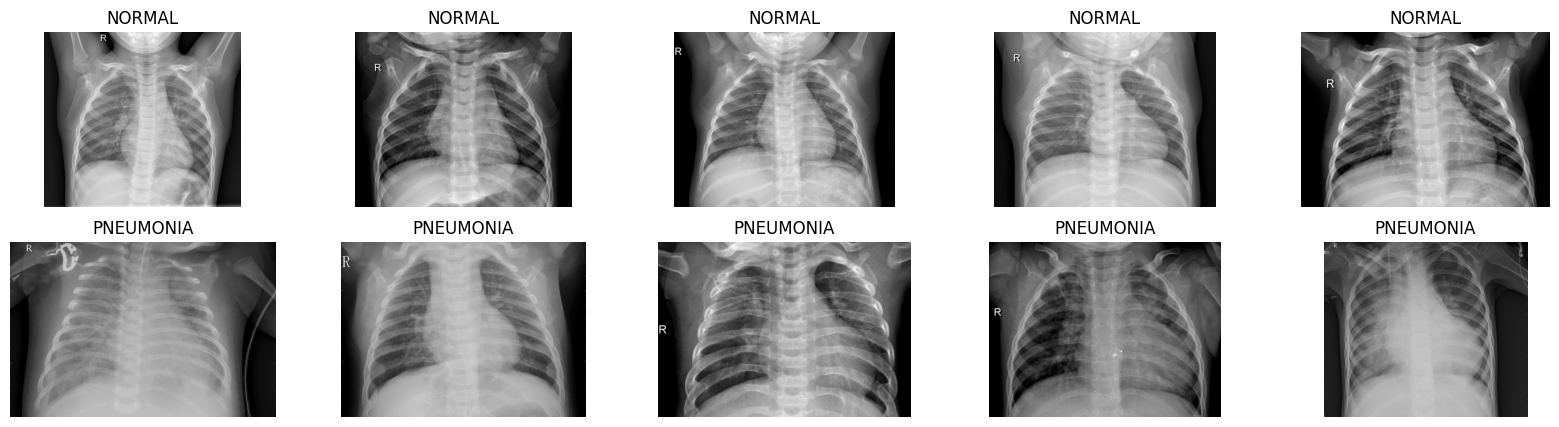

In [4]:
plt.figure(figsize=(20,5))
for category in os.listdir(traindir):
    if not category.startswith('.'):
        category_path = os.path.join(traindir, category)
        images_plotted = 0
        for img_name in os.listdir(category_path):
            if not img_name.startswith('.') and images_plotted < 5:
                img_path = os.path.join(category_path, img_name)
                image = cv2.imread(img_path)
                plt.subplot(2, 5, images_plotted + 1 + (0 if "NORMAL" in category else 5))
                plt.imshow(image, 'gray')
                plt.axis('off')
                plt.title(category)

                images_plotted += 1

plt.show();

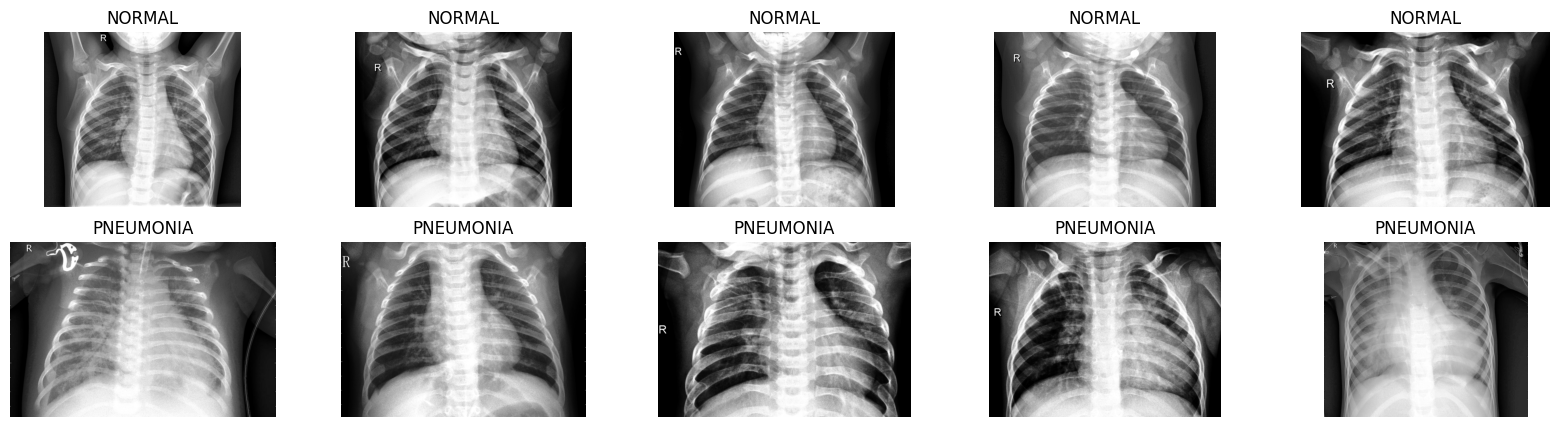

In [5]:
plt.figure(figsize=(20,5))
for category in os.listdir(traindir):
    if not category.startswith('.'):
        category_path = os.path.join(traindir, category)
        images_plotted = 0
        for img_name in os.listdir(category_path):
            if not img_name.startswith('.') and images_plotted < 5:
                img_path = os.path.join(category_path, img_name)
                image = cv2.imread(img_path, cv2.COLOR_BGR2GRAY)
                equ = cv2.equalizeHist(image)
                plt.subplot(2, 5, images_plotted + 1 + (0 if "NORMAL" in category else 5))
                plt.imshow(equ, 'gray')
                plt.axis('off')
                plt.title(category)

                images_plotted += 1

plt.show();

## Distribution of Images of each class

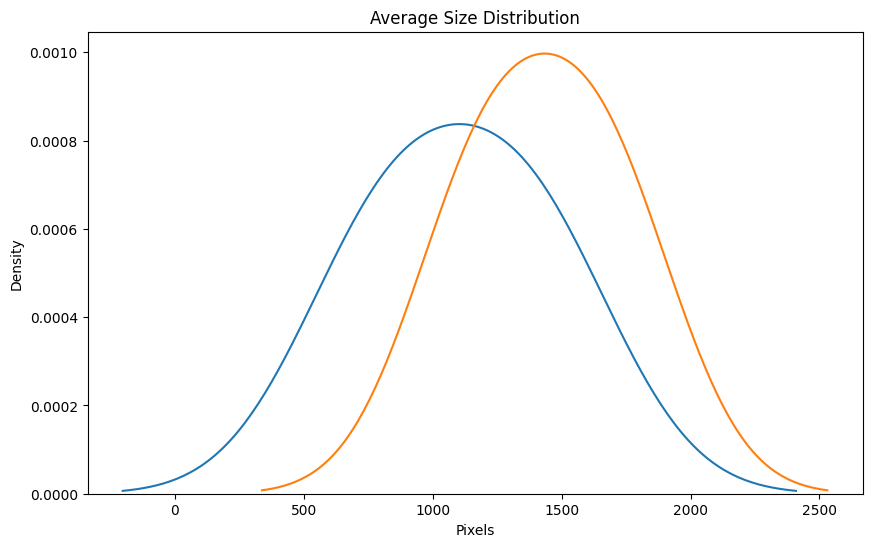

In [6]:
img_dsc = image_df.groupby('category').mean()
plt.figure(figsize=(10, 6))
sns.kdeplot(img_dsc['height'], label='Average Height')
sns.kdeplot(img_dsc['width'], label='Average Width')

plt.xlabel('Pixels')
plt.ylabel('Density')
plt.title('Average Size Distribution')

plt.show();

## Image Data Augmentation

In [7]:
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [8]:
from torchvision.datasets import ImageFolder 
batch_size = 128
# Define data transformations
data_transforms = {
    'train': image_transforms['train'],
    'val': image_transforms['val'],
    'test': image_transforms['test'],
}
datasets = {x: ImageFolder(root=os.path.join(datadir, x), transform=data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'val', 'test']}

features, labels = next(iter(dataloaders['train']))
features.shape, labels.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

## Model Training

In [9]:
def pretrained_model(model_name, num_classes=2):
    model = None

    if model_name == 'inception_v3':
        model = models.inception_v3(pretrained = True)

        for param in model.parameters():
            param.requires_grad = False

        in_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes),
            nn.LogSoftmax(dim=1)
        )
    
    elif model_name == 'vgg16':
        model = models.vgg16(pretrained = True)

        for param in model.parameters():
            param.requires_grad = False

        in_features = model.classifier[6].in_features
        model.classifier[6] = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes),
            nn.LogSoftmax(dim=1)
        )


    return model

In [10]:
model = pretrained_model('vgg16')
model.class_to_idx = datasets['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())

c:\Users\sumad\anaconda3\envs\cvip\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sumad\anaconda3\envs\cvip\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[(0, 'NORMAL'), (1, 'PNEUMONIA')]

In [11]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 4096])
torch.Size([256])
torch.Size([2, 256])
torch.Size([2])


## Model training function definition

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

def train(model, criterion, optimizer, train_loader, valid_loader, save_file_name,
          max_epochs_stop=3, n_epochs=10, print_every=2):
    # ...
    # Early stopping initialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf
    best_epoch = 0
    valid_max_acc = 0
    history = []

    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except AttributeError:
        model.epochs = 0
        print(f'Starting Training from epoch 0.\n')

    overall_start = time.time()
    # Main loop
    for epoch in range(n_epochs):
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0
        valid_acc = 0

        train_precision = 0.0
        valid_precision = 0.0
        train_recall = 0.0
        valid_recall = 0.0
        train_f1 = 0.0
        valid_f1 = 0.0

        model.train()
        start = time.time()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Clear gradients
            optimizer.zero_grad()
            if isinstance(model, models.inception.Inception3):
                # Inception model returns outputs in a tuple
                output, aux_output = model(data)
                loss1 = criterion(output, target)
                loss2 = criterion(aux_output, target)
                loss = loss1 + 0.4 * loss2
            else:
                output = model(data)
                loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)

            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))

            train_acc += accuracy.item() * data.size(0)
            train_precision += precision_score(target.cpu().numpy(), pred.cpu().numpy(), average='weighted')
            train_recall += recall_score(target.cpu().numpy(), pred.cpu().numpy(), average='weighted')
            train_f1 += f1_score(target.cpu().numpy(), pred.cpu().numpy(), average='weighted')

            print(f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {time.time() - start:.2f} seconds elapsed in epoch.', end='\r')

        else:
            model.epochs += 1
            with torch.no_grad():
                model.eval()
                for data, target in valid_loader:
                    output = model(data)
                    loss = criterion(output, target)
                    valid_loss += loss.item() * data.size(0)
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                    valid_acc += accuracy.item() * data.size(0)
                    valid_precision += precision_score(target.cpu().numpy(), pred.cpu().numpy(), average='weighted')
                    valid_recall += recall_score(target.cpu().numpy(), pred.cpu().numpy(), average='weighted')
                    valid_f1 += f1_score(target.cpu().numpy(), pred.cpu().numpy(), average='weighted')

                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                train_precision = train_precision / len(train_loader)
                valid_precision = valid_precision / len(valid_loader)
                train_recall = train_recall / len(train_loader)
                valid_recall = valid_recall / len(valid_loader)
                train_f1 = train_f1 / len(train_loader)
                valid_f1 = valid_f1 / len(valid_loader)

                history.append([train_loss, valid_loss, train_acc, valid_acc, train_precision, valid_precision, train_recall, valid_recall, train_f1, valid_f1])

                if (epoch + 1) % print_every == 0:
                    print(f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}')
                    print(f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%')
                    print(f'\t\tTraining Precision: {train_precision:.4f}\t Validation Precision: {valid_precision:.4f}')
                    print(f'\t\tTraining Recall: {train_recall:.4f}\t Validation Recall: {valid_recall:.4f}')
                    print(f'\t\tTraining F1 Score: {train_f1:.4f}\t Validation F1 Score: {valid_f1:.4f}')

                if valid_loss < valid_loss_min:
                    torch.save(model.state_dict(), save_file_name)
                    epochs_no_improve += 1
                    best_epoch = epoch
                    valid_loss_min = valid_loss # updating the valid loss minimum with new valid loss
                    if epochs_no_improve >= max_epochs_stop:
                        print(f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f}')
                        break
                else:
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss

    overall_end = time.time()
    print(f'\nTraining complete! Total time: {overall_end - overall_start:.2f} seconds')
    return model, history

## Training with VGG16 Model

In [13]:
vgg = pretrained_model('vgg16')

vgg_model, vgg_history, = train(
    vgg,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name='vgg16_model.pt',
    max_epochs_stop=3,
    n_epochs=10,
    print_every=1)

c:\Users\sumad\anaconda3\envs\cvip\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sumad\anaconda3\envs\cvip\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting Training from epoch 0.

Epoch: 0	100.00% complete. 258.92 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 0.7338 	Validation Loss: 0.6886
		Training Accuracy: 40.16%	 Validation Accuracy: 68.75%
		Training Precision: 0.6865	 Validation Precision: 0.8077
		Training Recall: 0.4017	 Validation Recall: 0.6875
		Training F1 Score: 0.3915	 Validation F1 Score: 0.6537
Epoch: 1	100.00% complete. 255.88 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.7344 	Validation Loss: 0.6886
		Training Accuracy: 39.44%	 Validation Accuracy: 68.75%
		Training Precision: 0.6746	 Validation Precision: 0.8077
		Training Recall: 0.3946	 Validation Recall: 0.6875
		Training F1 Score: 0.3847	 Validation F1 Score: 0.6537
Epoch: 2	100.00% complete. 258.32 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.7346 	Validation Loss: 0.6886
		Training Accuracy: 39.99%	 Validation Accuracy: 68.75%
		Training Precision: 0.6693	 Validation Precision: 0.8077
		Training Recall: 0.4003	 Validation Recall: 0.

In [14]:
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
vgg_history

[[0.7337955784943938,
  0.6885504126548767,
  0.401648773006135,
  0.6875,
  0.6864730377400208,
  0.8076923076923077,
  0.4016768292682927,
  0.6875,
  0.3914620583986086,
  0.6536796536796536],
 [0.7343845137057861,
  0.6885503530502319,
  0.3943634969325153,
  0.6875,
  0.674555960707317,
  0.8076923076923077,
  0.3946265243902439,
  0.6875,
  0.38470546184689636,
  0.6536796536796536],
 [0.7346358690525125,
  0.6885502934455872,
  0.39992331306627193,
  0.6875,
  0.6692851681715507,
  0.8076923076923077,
  0.40027947154471544,
  0.6875,
  0.3941630980188083,
  0.6536796536796536]]

## Plots for loss and Accuracy for training and validation of VGG16 model

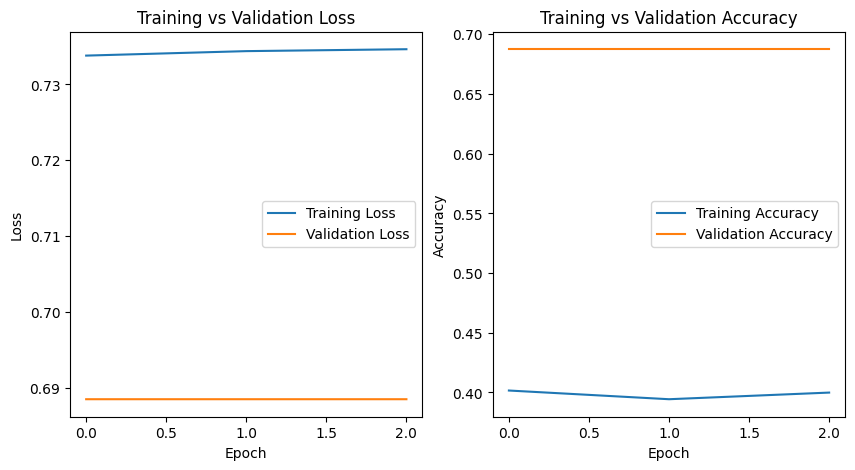

In [16]:
train_loss, valid_loss, train_acc, valid_acc, *_ = zip(*vgg_history)

plt.figure(figsize=(10, 5))

# Plot for Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.show();

## Predictions with VGG16 Model

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


vgg_model.eval()
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
classes = [0,1]
y_true = []
y_pred = []

for data, target in dataloaders['test']:
    output = vgg_model(data)
    loss = criterion(output, target)
    test_loss += loss.item() * data.size(0)
    _, pred = torch.max(output, 1)

    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy())

    for i in range(target.size(0)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

        y_true.append(label.item())
        y_pred.append(pred[i].item())

test_loss = test_loss / len(dataloaders['test'].dataset)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print('\nTest Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no testing examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

print('\nPrecision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1 Score: {:.4f}'.format(f1))

conf_matrix = confusion_matrix(y_true, y_pred)
print('\nConfusion Matrix:')
print(conf_matrix)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1


Test Loss: 0.697752

Test Accuracy of     0: 83% (195/234)
Test Accuracy of     1: 24% (96/390)

Test Accuracy (Overall): 46% (291/624)

Precision: 0.5940
Recall: 0.4663
F1 Score: 0.4309

Confusion Matrix:
[[195  39]
 [294  96]]


In [18]:
image_transforms = {
        'train': transforms.Compose([
            transforms.Resize(299),
            transforms.CenterCrop(299),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(299),
            transforms.CenterCrop(299),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(299),
            transforms.CenterCrop(299),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }




In [19]:
batch_size = 128
# Define data transformations
data_transforms = {
    'train': image_transforms['train'],
    'val': image_transforms['val'],
    'test': image_transforms['test'],
}
datasets = {x: ImageFolder(root=os.path.join(datadir, x), transform=data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'val', 'test']}

features, labels = next(iter(dataloaders['train']))
features.shape, labels.shape

(torch.Size([128, 3, 299, 299]), torch.Size([128]))

## Training with InceptionV3 Model

In [20]:
inception = pretrained_model('inception_v3')

criterion = nn.NLLLoss()
optimizer = optim.Adam(inception.parameters())

for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

inception_model, inception_history = train(
    inception,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name='inceptionv3_model.pt',
    max_epochs_stop=3,
    n_epochs=10,
    print_every=1)

c:\Users\sumad\anaconda3\envs\cvip\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sumad\anaconda3\envs\cvip\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([256, 2048])
torch.Size([256])
torch.Size([2, 256])
torch.Size([2])
Starting Training from epoch 0.



c:\Users\sumad\anaconda3\envs\cvip\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c:\Users\sumad\anaconda3\envs\cvip\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c:\Users\sumad\anaconda3\envs\cvip\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c:\Users\sumad\anaconda3\envs\cvip\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c:\Users\sumad\anaconda3\envs\cvip\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c:\Users\sumad\anaconda3\envs\cvip\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch: 0 	Training Loss: 0.3010 	Validation Loss: 1.5050
		Training Accuracy: 85.76%	 Validation Accuracy: 50.00%
		Training Precision: 0.8410	 Validation Precision: 0.2500
		Training Recall: 0.8573	 Validation Recall: 0.5000
		Training F1 Score: 0.8343	 Validation F1 Score: 0.3333
Epoch: 1	100.00% complete. 188.70 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.1823 	Validation Loss: 0.4293
		Training Accuracy: 90.64%	 Validation Accuracy: 75.00%
		Training Precision: 0.9163	 Validation Precision: 0.8333
		Training Recall: 0.9067	 Validation Recall: 0.7500
		Training F1 Score: 0.9052	 Validation F1 Score: 0.7333
Epoch: 2	100.00% complete. 188.86 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.1309 	Validation Loss: 0.4037
		Training Accuracy: 92.91%	 Validation Accuracy: 75.00%
		Training Precision: 0.9308	 Validation Precision: 0.8333
		Training Recall: 0.9291	 Validation Recall: 0.7500
		Training F1 Score: 0.9287	 Validation F1 Score: 0.7333

Early Stopping! Total epochs:

In [21]:
inception_model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [22]:
inception_history

[[0.30097693789956026,
  1.5050002336502075,
  0.8575536813472677,
  0.5,
  0.8409614459961765,
  0.25,
  0.8573424796747967,
  0.5,
  0.8342569777160518,
  0.3333333333333333],
 [0.18231214820607308,
  0.4293215870857239,
  0.9064417181570837,
  0.75,
  0.916315186058466,
  0.8333333333333333,
  0.9066946138211381,
  0.75,
  0.9051850644760686,
  0.7333333333333334],
 [0.1309461482554857,
  0.40371593832969666,
  0.9290644168122414,
  0.75,
  0.9308452511619627,
  0.8333333333333333,
  0.929052337398374,
  0.75,
  0.9286519348303501,
  0.7333333333333334]]

## Plots for loss and Accuracy for training and validation of Inceptionv3 model

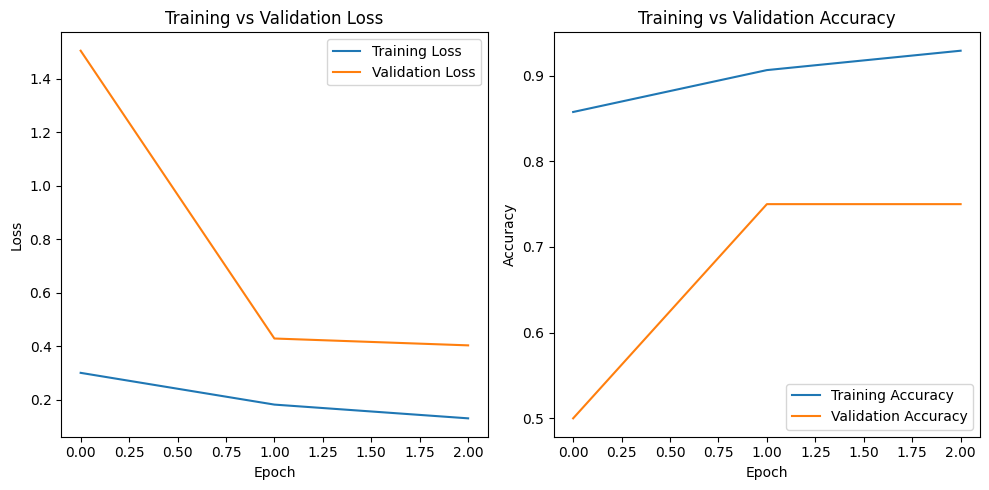

In [23]:
train_loss, valid_loss, train_acc, valid_acc, *_ = zip(*inception_history)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show();

## Predictions with Inception V3 Model

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


inception_model.eval()
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
classes = [0,1]
y_true = []
y_pred = []

for data, target in dataloaders['test']:
    output = inception_model(data)
    loss = criterion(output, target)
    test_loss += loss.item() * data.size(0)
    _, pred = torch.max(output, 1)

    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy())

    for i in range(target.size(0)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

        y_true.append(label.item())
        y_pred.append(pred[i].item())

test_loss = test_loss / len(dataloaders['test'].dataset)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print('\nTest Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no testing examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

print('\nPrecision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1 Score: {:.4f}'.format(f1))

conf_matrix = confusion_matrix(y_true, y_pred)
print('\nConfusion Matrix:')
print(conf_matrix)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri


Test Loss: 0.478108

Test Accuracy of     0: 56% (133/234)
Test Accuracy of     1: 96% (377/390)

Test Accuracy (Overall): 81% (510/624)

Precision: 0.8345
Recall: 0.8173
F1 Score: 0.8054

Confusion Matrix:
[[133 101]
 [ 13 377]]
